In [92]:
from eolearn.core.eoworkflow import LinearWorkflow, Dependency
from eolearn.core.eodata import FeatureType

# from sentinelhub import BBox, CRS
from sentinelhub import BBoxSplitter, BBox, CRS, CustomUrlParam

%matplotlib inline
import numpy as np
import math
import os
import numpy as np
import matplotlib.pyplot as plt
import datetime
import rasterio as rio

from eolearn.core import SaveToDisk, LoadFromDisk, EOTask, EOPatch, OverwritePermission
from eolearn.io import S2L1CWCSInput, AddSen2CorClassificationFeature, DEMWCSInput, S2L2AWCSInput, L8L1CWCSInput, ExportToTiff

In [93]:
# # reference time

# date_first_start = '2019-04-18'
# date_first_end = '2019-04-20'

# date_last_start = '2019-08-21'
# date_last_end = '2019-08-22'

In [3]:
class NormalBurningRatio(EOTask):
    """
    NBR = (9 - 12)/(9 + 12)
    DNBR = NBR_2 - NBR_1
    """
    def __init__(self, feature_name, band_a, band_b):
        self.feature_name = feature_name
        
        self.band_a_fetaure_name = band_a.split('/')[0]
        self.band_b_fetaure_name = band_b.split('/')[0]
        
        self.band_a_fetaure_idx = int(band_a.split('/')[-1])
        self.band_b_fetaure_idx = int(band_b.split('/')[-1])

    def execute(self, eopatch):
        band_a = eopatch.data[self.band_a_fetaure_name][..., self.band_a_fetaure_idx]
        band_b = eopatch.data[self.band_b_fetaure_name][..., self.band_b_fetaure_idx]

        nbr = (band_a - band_b)/(band_a + band_b)

        eopatch.add_feature(FeatureType.DATA, self.feature_name, nbr[..., np.newaxis])

        return eopatch  

In [4]:
roi_bbox = BBox(bbox=[27.48, 51.75, 27.57, 51.64], crs=CRS.WGS84)

In [5]:
layer = 'BANDS-S2-L1C'

custom_script = 'return [B04, B08, B08A, B09, B11, B12];'
input_task = S2L1CWCSInput(
    layer=layer,
    feature=(FeatureType.DATA, 'BANDS'), # save under name 'BANDS'
    custom_url_params={CustomUrlParam.EVALSCRIPT: custom_script}, # custom url for 6 specific bands
    resx='20m', # resolution x
    resy='20m', # resolution y
    maxcc=0.8, # maximum allowed cloud cover of original ESA tiles
)

add_ndvi = S2L1CWCSInput(layer='NDVI')

add_nbr = NormalBurningRatio('NBR', 'BANDS/3','BANDS/5')

tiff_location = './predicted_tiff_D'

add_dem = DEMWCSInput(layer='DEM')

#add_l2a = S2L2AWCSInput(layer='BANDS-S2-L2A')

add_sen2cor = AddSen2CorClassificationFeature('SCL', layer='BANDS-S2-L2A')

save = SaveToDisk('io_example', overwrite_permission=2, compress_level=1)

In [27]:
%%time

time_interval = ('2019-04-18', '2019-04-19')
workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 19.1 s


In [28]:
eopatch = result[save]
eopatch

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(1, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-18', '2019-04-19')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 19, 9, 34, 38)]
)

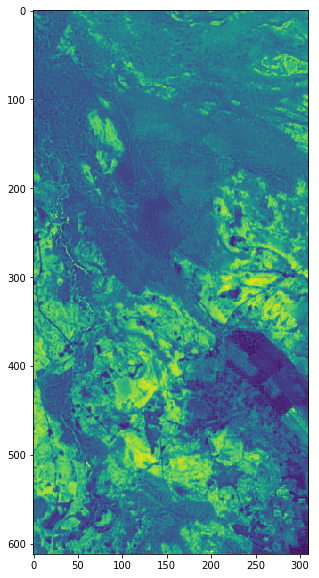

In [29]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch.data['NBR'][0].squeeze());

In [33]:
%%time

# time_interval = ('2019-05-31', '2019-06-09')
time_interval = ('2019-04-25', '2019-04-30')

workflow = LinearWorkflow(input_task, add_ndvi, add_nbr, add_sen2cor, add_dem, save)

result_new = workflow.execute({input_task: {'bbox': roi_bbox, 'time_interval': time_interval},
            save: {'eopatch_folder': 'eopatch'}})

Wall time: 15.8 s


In [34]:
eopatch_new = result_new[save]
eopatch_new

EOPatch(
  data: {
    BANDS: numpy.ndarray(shape=(1, 612, 310, 6), dtype=float32)
    NBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
    NDVI: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {
    IS_DATA: numpy.ndarray(shape=(1, 612, 310, 1), dtype=bool)
    SCL: numpy.ndarray(shape=(1, 612, 310, 1), dtype=int32)
  }
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {
    DEM: numpy.ndarray(shape=(612, 310, 1), dtype=float32)
  }
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {
    maxcc: 0.8
    service_type: 'wcs'
    size_x: '20m'
    size_y: '20m'
    time_difference: datetime.timedelta(days=-1, seconds=86399)
    time_interval: ('2019-04-25', '2019-04-30')
  }
  bbox: BBox(((27.48, 51.64), (27.57, 51.75)), crs=EPSG:4326)
  timestamp: [datetime.datetime(2019, 4, 26, 9, 32, 36)]
)

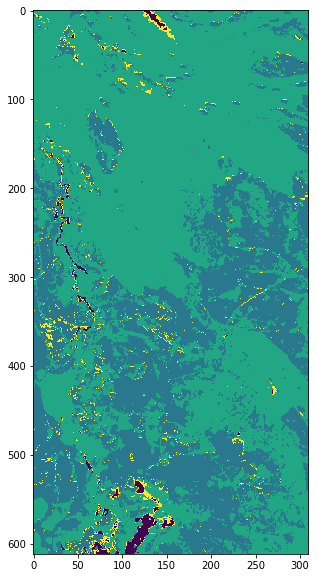

In [26]:
plt.figure(figsize=(10,10))
plt.imshow(eopatch_new.mask['SCL'][0].squeeze());

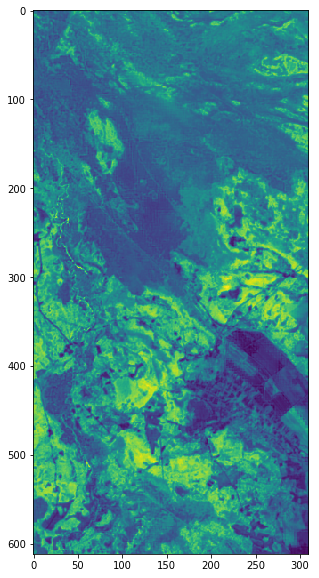

In [30]:
plt.figure(figsize=(10, 10))
plt.imshow(eopatch_new.data['NBR'][0].squeeze());

In [35]:
delta_nbr = eopatch.data['NBR'] - eopatch_new.data['NBR']
delta_nbr_1 = eopatch_new.data['NBR'] - eopatch.data['NBR']

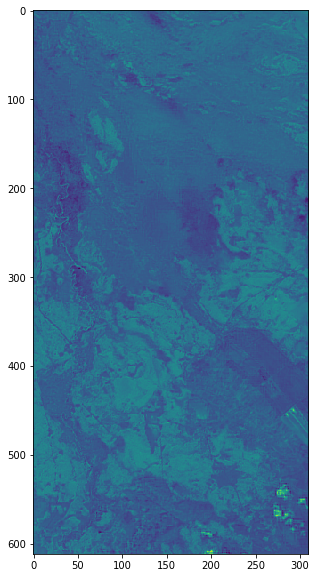

In [36]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr[0].squeeze());

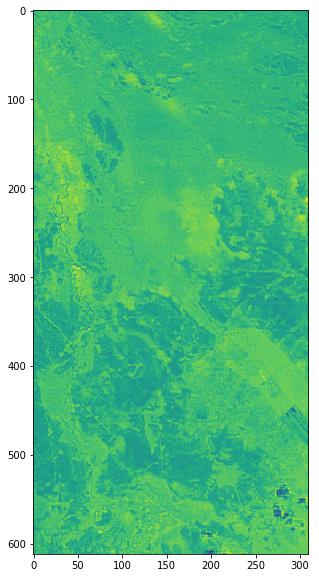

In [37]:
plt.figure(figsize=(10,10))
plt.imshow(delta_nbr_1[0].squeeze());

In [41]:
result_patch = EOPatch()
result_patch[FeatureType.DATA]['dNBR'] = delta_nbr_1

In [42]:
result_patch

EOPatch(
  data: {
    dNBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [43]:
result_patch.save('./result_patch', overwrite_permission=OverwritePermission.OVERWRITE_FEATURES)

In [44]:
patch2 = EOPatch.load('./result_patch')

In [45]:
patch2

EOPatch(
  data: {
    dNBR: numpy.ndarray(shape=(1, 612, 310, 1), dtype=float32)
  }
  mask: {}
  scalar: {}
  label: {}
  vector: {}
  data_timeless: {}
  mask_timeless: {}
  scalar_timeless: {}
  label_timeless: {}
  vector_timeless: {}
  meta_info: {}
  bbox: None
  timestamp: []
)

In [50]:
# # array of shape (h, w)
# dst_shape = delta_nbr_1.shape
# bbox=[27.48, 51.75, 27.57, 51.64]

# # bbox is the bounding box BBox instance used in Wms/WcsRequest 
# dst_transform = rasterio.transform.from_bounds(*roi_bbox.get_lower_left(), *roi_bbox.get_upper_right(),
#                                                width=dst_shape[1], height=dst_shape[0])
# dst_crs = 'EPSG:4326'
# # dst_crs = {'init': CRS.ogc_string(bbox.crs)}

# # Write it out to a file.
# with rasterio.open('result_file.tif', 'w', driver='GTiff',
#                               width=dst_shape[1], height=dst_shape[0],
#                               count=1, dtype=np.uint8, nodata=0,
#                               transform=dst_transform, crs=dst_crs) as dst:
#     dst.write(delta_nbr_1.astype(np.uint8))
      

In [49]:
# # TASK TO EXPORT TIFF
# load = EOPatch.load('./result_patch')

# export_tiff = ExportToTiff((FeatureType.DATA, 'dNBR'))
# tiff_location = './result_tiff'
# if not os.path.isdir(tiff_location):
#     os.makedirs(tiff_location)
    
# execution_args = [{'load' : {'eopatch_folder': 'result_patch'}, 
#                   'export_tiff': {'filename': '/result_tiff1.tiff'}}]   
    
# workflow_export = LinearWorkflow(load, export_tiff)    

# executor = EOExecutor(workflow_export, execution_args)            
# executor.run(workers=2, multiprocess=False)
# executor.make_report()

In [ ]:
result_export = workflow_export.execute()

In [ ]:
for i in range(1,2):
    print(i)

In [59]:
with rio.open('./exemple_tiff/example.tiff') as src:
    naip_data_ras = src.read()
    naip_meta = src.profile
    
    
naip_meta    

{'driver': 'GTiff', 'dtype': 'uint8', 'nodata': None, 'width': 1204, 'height': 1495, 'count': 3, 'crs': CRS.from_dict(init='epsg:4326'), 'transform': Affine(8.98106312292369e-05, 0.0, 24.059821,
       0.0, -5.432240802675634e-05, 52.836103), 'tiled': False, 'compress': 'deflate', 'interleave': 'pixel'}

In [60]:
naip_transform = naip_meta["transform"]
naip_crs = naip_meta["crs"]
dst_shape = delta_nbr_1.shape
bbox=[27.48, 51.75, 27.57, 51.64]

# View spatial attributes
naip_transform, naip_crs

(Affine(8.98106312292369e-05, 0.0, 24.059821,
        0.0, -5.432240802675634e-05, 52.836103),
 CRS.from_dict(init='epsg:4326'))

In [83]:
# with rasterio.open('result_file.tiff', 'w', driver='GTiff', width=dst_shape[1], height=dst_shape[0],
#                               count=1, dtype=np.uint8, nodata=0,
#                               transform=dst_transform, crs=dst_crs) as dst:
#     dst.write(delta_nbr_1.astype(np.uint8), 1)    

In [84]:
# # Write your the ndvi raster object
# with rio.open('result_file.tiff', 'w', **naip_meta) as dst:
#     dst.write(delta_nbr_1.astype(np.float64), 1)

In [95]:
min = np.amin(delta_nbr_1)
max = np.amax(delta_nbr_1)
print (min)
print (max)

-0.8751272
0.062227547


In [98]:
def diverse(array):             # returns the amplitude of the values
    min = np.amin(array)
    max = np.amax(array)
    
    if min <= 0 and max >= 0:
        diverse = abs(min) + max
    elif min >= 0 and max >= 0:
        diverse = max - min
    elif min <= 0 and max <= 0:
        diverse = min - max
    
    return(diverse)

In [100]:
a = diverse(delta_nbr_1)
print(a)

0.93735474


In [129]:
def normal(array):             # приведение значений массива к 8-битным знаечниям (0,..,255)
    min = np.amin(array)
    max = np.amax(array)
    
    if min <= 0 and max >= 0:
        diverse = abs(min) + max
        
        positive_values = diverse + min      # получение положительного промежутка
#        negative_values = diverse - positive_values   # получение отрицательного промежутка
        
        positive_values_part = positive_values / diverse    # получение доли положительного промежутка
        negative_values_part = 1 - positive_values_part     # получение доли отрицательного промежутка
        
        pos8bit = round(positive_values_part * 256)
        neg8bit = 256 - pos8bit
        
        neg_step = (min - 0.00001) / neg8bit    # получение шага яркости равного изменению на 1
        
    elif min >= 0 and max >= 0:
        diverse = max - min
        
        
    elif min <= 0 and max <= 0:
        diverse = min - max
        
    return (positive_values_part, negative_values_part, pos8bit, neg8bit, neg_step)    

In [130]:
print(normal(delta_nbr_1))

(0.066386335, 0.9336136654019356, 17.0, 239.0, -0.003661661909255024)


In [136]:
print(delta_nbr_1)

IndexError: index 1 is out of bounds for axis 0 with size 1